In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
from pathlib import Path
import tarfile
from io import StringIO
import skimage
import matplotlib.patches
import xarray as xr
import xrft
import pyproj
import pygmt
import euler

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = Path('../data/rio-magnetic.nc')
data = xr.open_dataset(data_path, engine='netcdf4')
coordinates = [data.easting_m.values, data.northing_m.values, data.height_m.values]
data

<xarray.Dataset> Size: 9MB
Dimensions:     (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m   (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m  (northing_m) float64 6kB -2.373e+06 -2.372e+06 ... -2.295e+06
    height_m    (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nT      (northing_m, easting_m) float64 4MB ...

In [3]:
data["deriv_east"] = hm.derivative_easting(data.tfa_nT)
data["deriv_north"] = hm.derivative_northing(data.tfa_nT)

magnetic_grid_no_height = data.drop_vars("height_m")
pad_width = {
    "easting_m": data.easting_m.size // 3,
    "northing_m": data.northing_m.size // 3,
}
padded = xrft.pad(
    magnetic_grid_no_height.tfa_nT, pad_width, mode="linear_ramp", constant_values=None
)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
data = data.assign(
    total_gradient=np.sqrt(data.deriv_east**2 + data.deriv_north**2 + data.deriv_up**2)
)
data

<xarray.Dataset> Size: 27MB
Dimensions:         (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m       (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m      (northing_m) float64 6kB -2.373e+06 ... -2.295e+06
    height_m        (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0
Data variables:
    tfa_nT          (northing_m, easting_m) float64 4MB 153.7 154.9 ... 123.8
    deriv_east      (northing_m, easting_m) float64 4MB 0.01172 ... -0.02336
    deriv_north     (northing_m, easting_m) float64 4MB 0.009082 ... 0.01421
    deriv_up        (northing_m, easting_m) float64 4MB -0.01014 ... -0.02335
    total_gradient  (northing_m, easting_m) float64 4MB 0.01796 ... 0.03595

## Euler Deconvolution

In [4]:
ed_window_size = 10e3
ed_window_step = ed_window_size / 4

In [5]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=ed_window_size,
        window_step=ed_window_step,
        keep=0.3,
    ).fit_grid(
        data,
        data_names=("tfa_nT", "deriv_east", "deriv_north", "deriv_up"),
        coordinate_names=("easting_m", "northing_m", "height_m"),
    )

CPU times: user 13.8 s, sys: 305 ms, total: 14.1 s
Wall time: 14.1 s


## Blob Detection

In [6]:
stretched = skimage.exposure.rescale_intensity(
    data.total_gradient, 
    in_range=tuple(np.percentile(data.total_gradient, (0.5, 99.5))),
)
data = data.assign(tga_stretched=xr.DataArray(stretched, coords=data.coords))
data

<xarray.Dataset> Size: 31MB
Dimensions:         (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m       (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m      (northing_m) float64 6kB -2.373e+06 ... -2.295e+06
    height_m        (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0
Data variables:
    tfa_nT          (northing_m, easting_m) float64 4MB 153.7 154.9 ... 123.8
    deriv_east      (northing_m, easting_m) float64 4MB 0.01172 ... -0.02336
    deriv_north     (northing_m, easting_m) float64 4MB 0.009082 ... 0.01421
    deriv_up        (northing_m, easting_m) float64 4MB -0.01014 ... -0.02335
    total_gradient  (northing_m, easting_m) float64 4MB 0.01796 ... 0.03595
    tga_stretched   (northing_m, easting_m) float64 4MB 0.03705 ... 0.08392

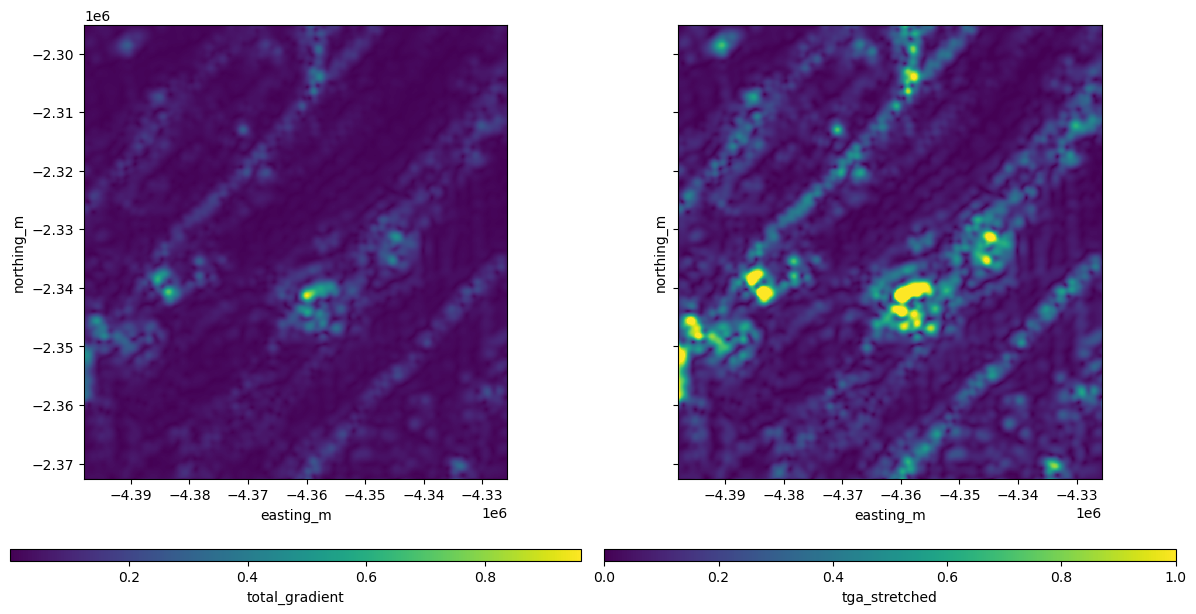

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["total_gradient", "tga_stretched"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Window selection using blob detection

In [8]:
def detect_anomalies(
    data, size_range, size_increment=2, nsizes=10, threshold=0.5, overlap=0.5, exclude_border=0
):
    """
    Run the blob detection and produce bounding boxes in data coordinates
    """
    min_sigma, max_sigma = [0.5 * i for i in size_range]
    spacing = np.mean([np.abs(data.easting_m[1] - data.easting_m[0]), np.abs(data.northing_m[1] - data.northing_m[0])])
    iy, ix, sigma_pix = skimage.feature.blob_log(
        data,
        min_sigma=min_sigma / spacing,
        max_sigma=max_sigma / spacing,
        threshold=threshold,
        num_sigma=nsizes,
        overlap=overlap,
        exclude_border= int(exclude_border / spacing),
    ).T
    blob_coords = (data.easting_m.values[ix.astype("int")], data.northing_m.values[iy.astype("int")])
    blob_sizes = sigma_pix * np.sqrt(2) * spacing * size_increment
    windows = [
        [x - size, x + size, y - size, y + size]
        for size, x, y in zip(blob_sizes, *blob_coords)
    ]
    return windows

In [44]:
windows = detect_anomalies(
    data.tga_stretched, 
    size_range=[2e3, 10e3],
    size_increment=1.0,
    threshold=0.02,
    overlap=0.5,
    nsizes=10,
    exclude_border=200
)

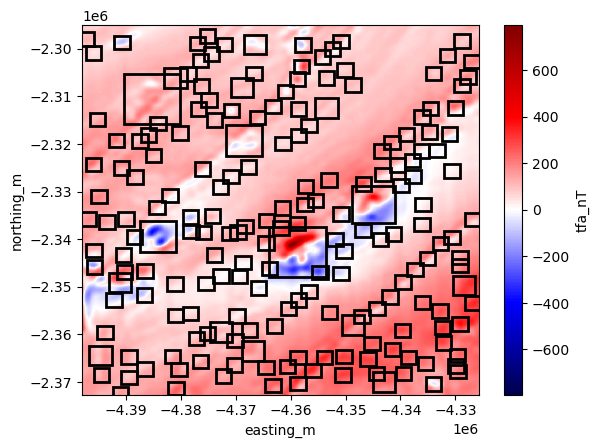

In [45]:
ax = plt.subplot(111)
data.tfa_nT.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect) 

### Block averaging

In [46]:
# Show windows centers
center_easting = []
center_northing = []

for window in windows:
    center_easting.append( (window[0] + window[1]) / 2)
    center_northing.append((window[2] + window[3]) / 2)
region = vd.get_region(([center_easting, center_northing]))
block_spacing = 2e3 # meters
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.5)),
    drop_coords=False
)

blocked_center, _ = reducer.filter([np.asarray(center_easting), np.asarray(center_northing)], data=np.zeros(np.shape(center_easting)))
print(np.shape(blocked_center))

(2, 193)


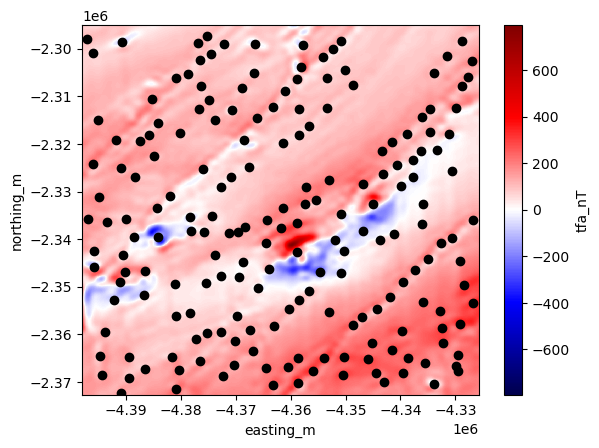

In [47]:
ax = plt.subplot(111)
data.tfa_nT.plot.pcolormesh(ax=ax, cmap="seismic")
ax.scatter(blocked_center[0], blocked_center[1], c='k')
plt.show()

In [48]:
%%time
ei = {1: [], 2: [], 3: []}
window_sizes = np.arange(1e3, 15e3, 0.5e3)

# Avoid windows extrapolating the data boundaries
easting_min, easting_max = data.easting_m.min(), data.easting_m.max()
northing_min, northing_max = data.northing_m.min(), data.northing_m.max()

for i in range(np.shape(blocked_center)[1]):
    # Calculate the center of the window
    center_easting = blocked_center[0][i]
    center_northing = blocked_center[1][i]
    for si in ei.keys():
        tolerance = np.inf
        for window_size in window_sizes:
            # Get the size of the window
            easting_start = center_easting - window_size / 2
            easting_end = center_easting + window_size / 2
            northing_start = center_northing - window_size / 2
            northing_end = center_northing + window_size / 2
            # Verify if the window is within the data boundaries
            if (easting_start < easting_min or easting_end > easting_max or
                northing_start < northing_min or northing_end > northing_max):
                continue
            # Get the sliced data
            easting_range = slice(easting_start, easting_end)
            northing_range = slice(northing_start, northing_end)
            data_slice = data.sel(easting_m=easting_range, northing_m=northing_range)

            ei_result = euler.EulerInversion(si).fit_grid(data_slice, 
                                                           data_names=(['tfa_nT',
                                                                        'deriv_east',
                                                                        'deriv_north',
                                                                        'deriv_up']
                                                                      ),
                                                           coordinate_names=(['easting_m',
                                                                              'northing_m',
                                                                              'height_m']
                                                                            )
                                                          )
            variance = np.sum(np.diag(ei_result.covariance_)[:3])
            x, y = ei_result.location_[:2]
            if (variance <= tolerance and
                x > easting_start and x < easting_end and
                y > northing_start and y < northing_end
               ):
                chosen_window = [easting_start, easting_end, northing_start, northing_end]
                tolerance = variance
        
        chosen_easting_range = slice(chosen_window[0], chosen_window[1])
        chosen_northing_range = slice(chosen_window[2], chosen_window[3])
        chosen_data_slice =  data.sel(easting_m=chosen_easting_range, northing_m=chosen_northing_range)     
        ei[si].append(euler.EulerInversion(si).fit_grid(chosen_data_slice,
                                                        data_names=(['tfa_nT',
                                                                    'deriv_east',
                                                                    'deriv_north',
                                                                    'deriv_up']
                                                                   ),
                                                        coordinate_names=(['easting_m',
                                                                          'northing_m',
                                                                          'height_m']
                                                                         )
                                                       )
                     )

CPU times: user 1h 13min 10s, sys: 10.5 s, total: 1h 13min 20s
Wall time: 10min 28s


In [49]:
print(len(ei[1]))
print(len(ei[2]))
print(len(ei[3]))

193
193
193


In [50]:
ei[1][0].data_misfit_[-1]

np.float64(0.037001775896599254)

In [51]:
ei_final = {1: [], 2: [], 3: []}
for si1, si2, si3 in zip(ei[1], ei[2], ei[3]):
    si_dict = {1: si1, 2: si2, 3: si3}
    chosen_si = min(si_dict, key=lambda si: si_dict[si].merit_)
    ei_final[chosen_si].append(si_dict[chosen_si])

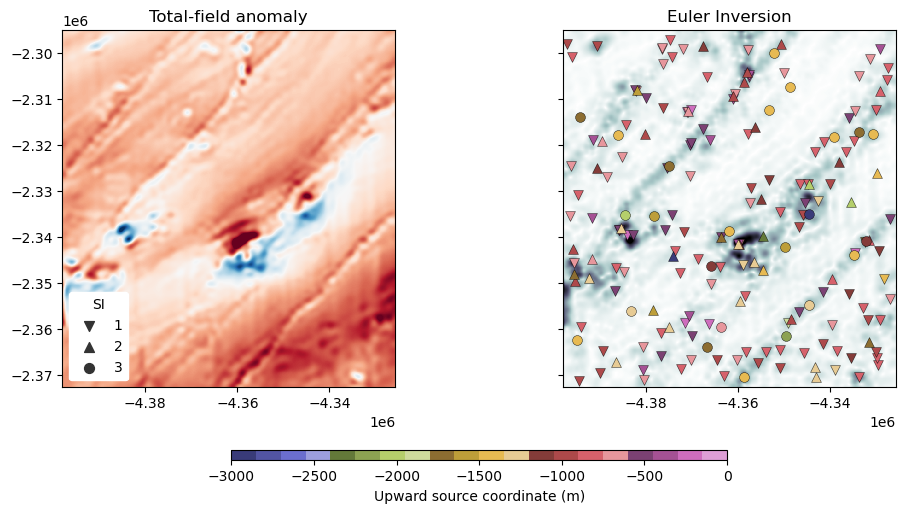

In [52]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), layout="constrained", sharey=True
)

subplot_labels = [f"{i})" for i in "ab"]
units = {
    "tfa_nT": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nT": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


ax = axes[0]
ax.set_aspect("equal")
scale = np.percentile(data.tfa_nT.values, 99.8)
tmp = data.tfa_nT.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=-scale,
    cmap="RdBu_r",
)

ax.set_title(data_names['tfa_nT'])



# Euler inversion
labels = {}
ax = axes[1]
ax.set_title("Euler Inversion")


ax.set_aspect("equal")
scale = np.percentile(data.total_gradient.values, 99.9)
tmp = data.total_gradient.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=0,
    cmap="bone_r",
)

for si, marker in zip(ei_final.keys(), markers):
    for k, solution in enumerate(ei_final[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[:],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)